# Applying Principal Component Analysis to Cold Atom Images - Application
## August 12, 2017
## Hiro Miyake
### Contents
1. [Introduction](#introduction)
2. [Initial Setup and Required Modules](#setup)
3. [Read in the IGOR Files](#igor)
4. [Initialize the coldAtomImages Class and Some Preliminaries](#initialize)
5. [Finding and Exploring the Principal Components](#findpca)
6. [Applying Principal Components Subtraction](#applypca)

<a id="introduction"></a>
## 1. Introduction

In this Jupyter notebook, I describe how to use the class I developed in Python called the `coldAtomImages`, which can apply principal component analysis to accurately analyze cold atom images. The motivation and theory behind this technique is described in the companion theory Jupyter notebook [here](https://github.com/hiromiyake/DataAnalysisProjects/blob/master/PCAforColdAtomImages/PCAColdAtomImages-Theory.ipynb).

<a id="setup"></a>
## 2. Initial Setup and Required Modules
First let's import the necessary modules. The heart of the method is in the `coldatomimages_v1`.

In [1]:
%matplotlib inline
#%pylab inline
#pylab.rcParams['figure.figsize'] = (10, 6)

from __future__ import division
import numpy as np
import igor.binarywave as bw
import matplotlib.pyplot as plt
import os
import coldatomimages_v1 as coldatomimages

<a id="igor"></a>
## 3. Read in the IGOR Files
Next step is to read in the image files. Note the images are stores as .ibw files, which is the file format for [IGOR Pro](https://www.wavemetrics.com/products/igorpro/igorpro.htm), a scientific programming software developed by [WaveMetrics](https://www.wavemetrics.com). To read these into Python, I use the open-source IGOR Python module obtainable from [here](https://pypi.python.org/pypi/igor).

In [2]:
direct = '/Users/hiro/Documents/data-science/python/pca/ibw_files' ## For Mac
#direct = 'C:\Users\Hiro\Documents\code\pca\data\images170405' ## For Windows
filenames = os.listdir(direct)

filenames_ibw = []
for i in filenames:
    if i[-3:] == 'ibw':
        filenames_ibw.append(direct+'/'+i) ## For Mac
        #filenames_ibw.append(direct+'\\'+i) ## For Windows

imagelist = []
firstimage = True
for i in filenames_ibw:
    ## x is a dictionary with keys 'version' and 'wave'
    ## The value of 'wave' is in turn a dictionary
    x = bw.load(i)
    
    ## 'wData' contains the images
    ## This is a numpy array that has size 3 Ny x Nx
    ## This is a stack of 3 images
    ## Grasshopper has image size 1928 x 1448 pixels
    xwave = x['wave']
    imagestack = xwave['wData']
    imagestack = np.matrix(imagestack)
    
    if firstimage:
        stacksize = imagestack.shape
        imagesize = []
        imagesize.append(stacksize[0]/3)
        imagesize.append(stacksize[1])
        firstimage = False
    
    ## Chop the super-image into 3 images
    ipwa = imagestack[:imagesize[0]].T
    ipwoa = imagestack[imagesize[0]:imagesize[0]*2].T
    idark = imagestack[imagesize[0]*2:].T
    imageset = []
    imageset.append(ipwa)
    imageset.append(ipwoa)
    imageset.append(idark)
    imagelist.append(imageset)

/Users/hiro/anaconda/lib/python2.7/site-packages/numpy/matrixlib/defmatrix.py:318: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  out = N.ndarray.__getitem__(self, index)


<a id="initialize"></a>
## 4. Initialize the coldAtomImages Class and Some Preliminaries
Now we can start using the class I developed on the images. First we initialize the object and read out the image sizes and how many images are in here.

In [3]:
## Create AMOImageSet object with imagelist
myImageSet = coldatomimages.coldAtomImages(imagelist)
## Check image dimensions
print 'Original image size: ' + str(myImageSet.getImageSize())
## Check how many images there are
print 'Number of images: ' + str(myImageSet.getNImage())

Original image size: (1448, 1928)
Number of images: 16


We can also specify a `whichimage` variable which shows which image we will be looking at.

In [4]:
whichimage = 13 ## Choose which image you want to see

Now let's take a look at the first image.

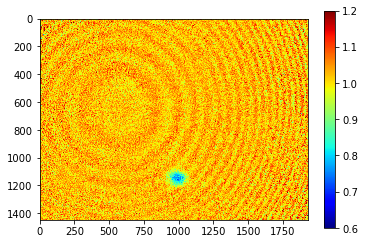

In [5]:
colorlim=(0.6,1.2) ## Set the color scale limits
plt.imshow(myImageSet.showAtomsOriginal(whichimage), cmap='jet', clim=colorlim)
plt.colorbar()

We see the atoms around the bottom center. However, note that the image contains a lot of empty space which is irrelevant to the atoms. So for ease and speed of data processing, it would make sense to crop the image only to the relevant region. Let's do this now.

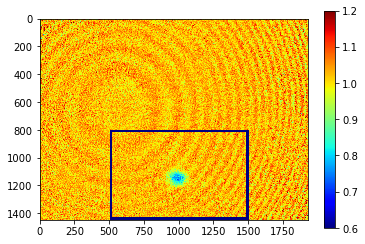

In [6]:
## The image is pretty big, so let's crop it for analysis
##  [vertical_left vertical_right; horizontal_top horizontal_bottom]
##  [x value       x value       ; y value        y value          ]
crop = [[500,1500], [800,1448]]
## Use line below to visually check cropped image
plt.imshow(myImageSet.showCropRegion(mask = crop, iimage = whichimage), cmap='jet', clim=(0.6,1.2))
plt.colorbar()

Now actually crop the images.

Cropped image size: (648, 1000)


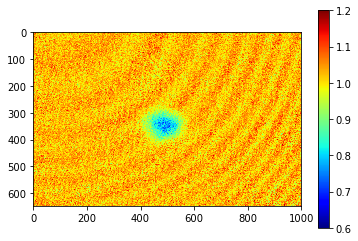

In [7]:
## Now actually crop the images
myImageSet.cropImages(crop)
## Check cropped image dimensions
print 'Cropped image size: ' + str(myImageSet.getImageSizeCrop())
## Look at cropped image
plt.imshow(myImageSet.showAtoms(whichimage), cmap='jet', clim=colorlim)
plt.colorbar()

<a id="findpca"></a>
## 5. Finding and Exploring the Principal Components
Now that we have cropped images, let's extract the principal components of the PWOA.

In [8]:
myImageSet.PWOABases(myImageSet.getNImage())

First, let's take a look at one of the PWOAs.

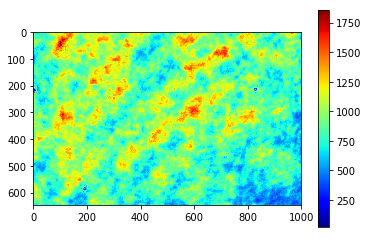

In [9]:
plt.imshow(myImageSet.getImageListCrop()[0][1], cmap = 'jet')
plt.colorbar()

Let's take a look at the mean PWOA.

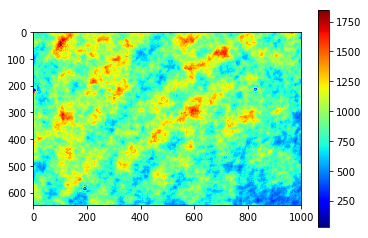

In [10]:
plt.imshow(myImageSet.getPWOAMean(), cmap = 'jet')
plt.colorbar()

Those look pretty similar as one would expect. Now let's subtract the mean from the first PWOA and see what we have left. The principal components should be able to explain these.

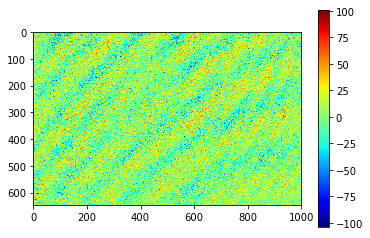

In [11]:
plt.imshow(myImageSet.getPWOAMean()-myImageSet.getImageListCrop()[0][1], cmap = 'jet')
plt.colorbar()

Let's see what the residual of the second image looks like.

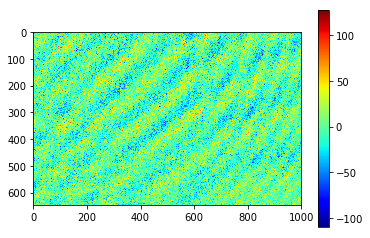

In [12]:
plt.imshow(myImageSet.getPWOAMean()-myImageSet.getImageListCrop()[1][1], cmap = 'jet')
plt.colorbar()

Now let's take a look at a few of the principal components.

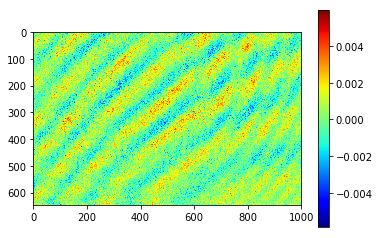

In [13]:
plt.imshow(myImageSet.showPWOABases(iimage = 0), cmap = 'jet')
plt.colorbar()

Second principal component...

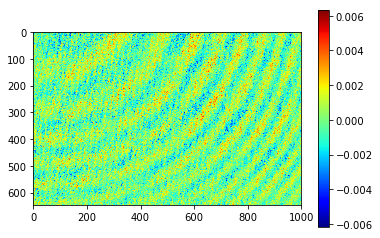

In [14]:
plt.imshow(myImageSet.showPWOABases(iimage = 1), cmap = 'jet')
plt.colorbar()

Third principal component.

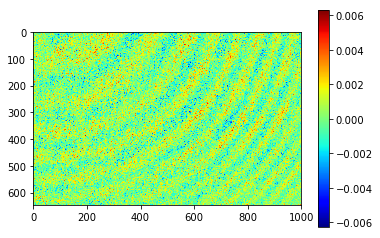

In [15]:
plt.imshow(myImageSet.showPWOABases(iimage = 2), cmap = 'jet')
plt.colorbar()

<a id="applypca"></a>
## 6. Applying Principal Components Subtraction
OK, now let's do the PCA subtraction. First we need to specify the mask region around the atoms.

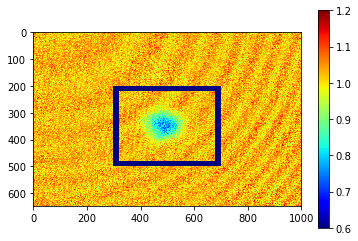

In [16]:
## Now let's choose a mask region for principal component analysis
mask = [[300,700], [200,500]]
plt.imshow(myImageSet.showMaskRegion(mask = mask, iimage = whichimage), cmap = 'jet', clim = colorlim)
plt.colorbar()

Now process the data with this mask and apply PCA.

In [17]:
## Now process the data with PCA
myImageSet.PCAImageList(mask, 1)

Done! Let's see what this looks like.

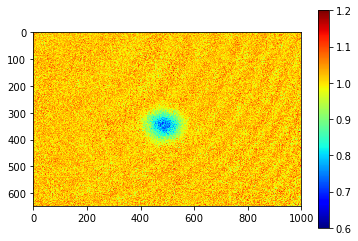

In [18]:
## Show PCAed image
plt.imshow(myImageSet.showAtomsPCA(whichimage), cmap='jet', clim=colorlim)
plt.colorbar()

Let's look at what this looks like without PCA.

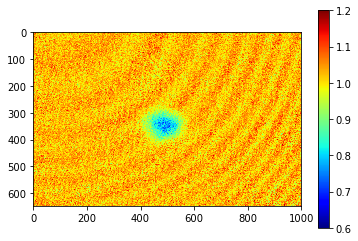

In [19]:
plt.imshow(myImageSet.showAtoms(whichimage), cmap='jet', clim = colorlim)
plt.colorbar()

If we visually compare the two, certainly the PCAed image looks like there are less fringes. But the method is not perfect at eliminating fringes. This could be because the fringes are not common in between PWA and PWOA, so that it is improper to use the fringes of PWOA to construct the bases. Or the noises are not Gaussian distributed. There is room for improvement, but this is certainly an improvement on the original image.